# **Preprocessing**

In [ ]:
!pip install pydicom
!pip install dicom
!pip install opencv-python
!pip install natsort
!pip install simpleitk
!pip install pydot

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2, pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from natsort import natsorted

import tensorflow as tf

import sys
import random
import warnings
warnings.filterwarnings('ignore')

import cv2
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib
import SimpleITK as sitk



from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
2023-12-16 19:37:43.080422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
from natsort import natsorted
from glob import glob
import os
import pydicom
import cv2

# 디렉토리 경로 상수 정의
CT_PATH_DIR = '/Users/user/Desktop/test/CT/'
MASK1_PATH_DIR = '/Users/user/Desktop/test/MASK1/'
MASK2_PATH_DIR = '/Users/user/Desktop/test/MASK2/'

# CT 이미지, 마스크 1 이미지, 마스크 2 이미지를 저장할 리스트 초기화
cts = []
mask1 = []
mask2 = []

image_size = (512, 512)

def load_and_process_images(image_paths, image_list):
    for image_path in image_paths:
        slice = pydicom.read_file(image_path)
        s = float(slice.RescaleSlope)
        b = float(slice.RescaleIntercept)
        image = s * slice.pixel_array + b
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_LINEAR).astype(np.int16)  # 이미지 크기 조정 및 데이터 타입 변경
        image_list.append(image)

# CT 이미지 파일 경로 리스트 생성, CT 이미지 로딩 및 스케일링 적용
for i in range(1, 4):  # 1부터 3까지의 하위 폴더를 탐색
    file_ct_paths = natsorted(glob(os.path.join(CT_PATH_DIR, str(i), '*.DCM')))
    load_and_process_images(file_ct_paths, cts)

# mask1 이미지 파일 경로 리스트 생성 및 mask1 이미지 로딩 및 스케일링 적용
for i in range(1, 4):  # 1부터 3까지의 하위 폴더를 탐색
    file_mask1_paths = natsorted(glob(os.path.join(MASK1_PATH_DIR, str(i), '*.dcm')))
    load_and_process_images(file_mask1_paths, mask1)

# mask2 이미지 파일 경로 리스트 생성 및 mask2 이미지 로딩 및 스케일링 적용
for i in range(1, 4):  # 1부터 3까지의 하위 폴더를 탐색
    file_mask2_paths = natsorted(glob(os.path.join(MASK2_PATH_DIR, str(i), '*.dcm')))
    load_and_process_images(file_mask2_paths, mask2)


#리스트를 NumPy 배열로 변환
cts_np = np.array(cts)
mask1_np = np.array(mask1)
mask2_np = np.array(mask2)


In [4]:
print("cts_np.shape", cts_np.shape)
print("mask1_np.shape", mask1_np.shape)
print("mask2_np.shape", mask2_np.shape)

cts_np.shape (504, 512, 512)
mask1_np.shape (504, 512, 512)
mask2_np.shape (504, 512, 512)


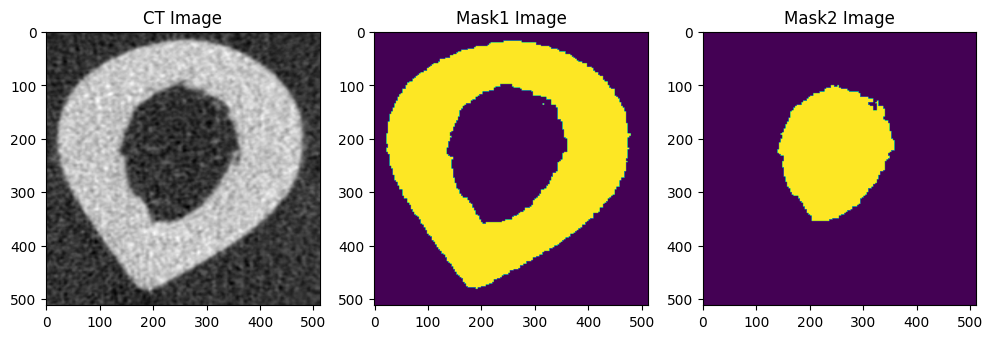

Mask1와 Mask2 이미지는 다릅니다.


In [135]:
import matplotlib.pyplot as plt
import random

# 랜덤하게 이미지 인덱스 선택
num_samples = len(cts_np)
random_index = random.randint(0, num_samples - 1)

# 선택한 랜덤 이미지 가져오기
ct_image = cts_np[random_index]
mask1_image = mask1_np[random_index]
mask2_image = mask2_np[random_index]

# 이미지 시각화
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ct_image, cmap='gray')
plt.title('CT Image')

plt.subplot(132)
plt.imshow(mask1_image, cmap='viridis')  # Mask1 이미지
plt.title('Mask1 Image')

plt.subplot(133)
plt.imshow(mask2_image, cmap='viridis')  # Mask2 이미지
plt.title('Mask2 Image')

plt.show()

# 두 가지 마스크 이미지 비교
if np.array_equal(mask1_image, mask2_image):
    print("Mask1와 Mask2 이미지는 동일합니다.")
else:
    print("Mask1와 Mask2 이미지는 다릅니다.")


In [6]:
import numpy as np

# mask1_np의 최소값 및 최대값
min_value_mask1 = np.min(mask1_np)
max_value_mask1 = np.max(mask1_np)

# mask2_np의 최소값 및 최대값
min_value_mask2 = np.min(mask2_np)
max_value_mask2 = np.max(mask2_np)

print(f"Mask1 최소값: {min_value_mask1}")
print(f"Mask1 최대값: {max_value_mask1}")

print(f"Mask2 최소값: {min_value_mask2}")
print(f"Mask2 최대값: {max_value_mask2}")

Mask1 최소값: 0
Mask1 최대값: 1
Mask2 최소값: 0
Mask2 최대값: 1


In [7]:
import numpy as np

# 이미지 개수
num_images = len(cts_np)

# 초기화된 combined_image 생성
combined_image = []

# 각 이미지를 루프를 사용하여 합침
for i in range(num_images):
    ct_image = cts_np[i]
    mask1_image = mask1_np[i]
    mask2_image = mask2_np[i]
    
    # 각 이미지를 정확한 채널에 배치
    current_image = np.stack((ct_image, mask1_image, mask2_image), axis=-1)
    
    combined_image.append(current_image)

# 합쳐진 이미지 리스트를 NumPy 배열로 변환
combined_image = np.array(combined_image)

print(combined_image.shape)



(504, 512, 512, 3)


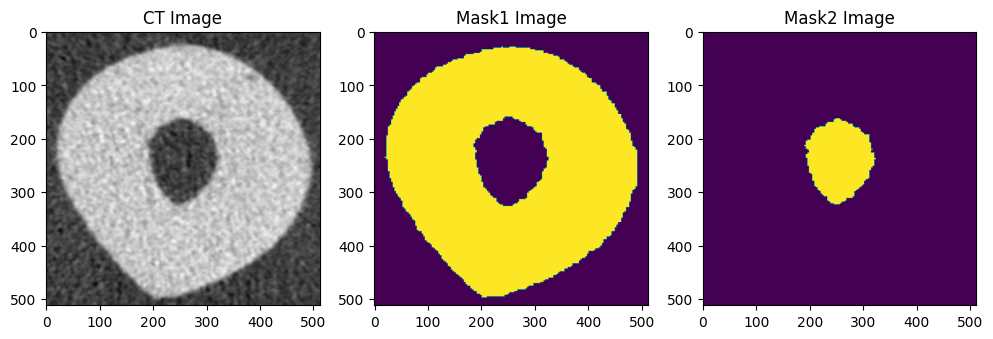

In [8]:
import matplotlib.pyplot as plt
import random

# 이미지 개수
num_images = combined_image.shape[0]

# 랜덤 이미지 인덱스 선택
random_index = random.randint(0, num_images - 1)

# 1 채널, 2 채널, 3 채널의 이미지 가져오기
ct_image = combined_image[random_index, :, :, 0]  # 1 채널 (CT 이미지)
mask1_image = combined_image[random_index, :, :, 1]  # 2 채널 (Mask1 이미지)
mask2_image = combined_image[random_index, :, :, 2]  # 3 채널 (Mask2 이미지)

# 각 채널의 이미지 시각화
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(ct_image, cmap='gray')
plt.title('CT Image')

plt.subplot(132)
plt.imshow(mask1_image, cmap='viridis')
plt.title('Mask1 Image')

plt.subplot(133)
plt.imshow(mask2_image, cmap='viridis')
plt.title('Mask2 Image')

plt.show()


In [94]:
# Building unet model

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from keras.models import Model
import numpy as np

# U-Net 모델 정의
def u_model(input_layer, start_neurons, DropoutRatio=0.25, num_classes=2):

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)


    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = BatchNormalization()(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = BatchNormalization()(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = BatchNormalization()(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)


    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = BatchNormalization()(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)


    output_layer_mask1 = Conv2D(num_classes, (1, 1), activation='softmax', name='mask1')(uconv1)
    output_layer_mask2 = Conv2D(num_classes, (1, 1), activation='softmax', name='mask2')(uconv1)


    return output_layer_mask1, output_layer_mask2

# 클래스 수 설정 (mask1과 mask2 두 개의 클래스)
num_classes = 2

# 입력 이미지 및 마스크를 모델에 전달

# 모델 초기화
input_shape = (512, 512, 3)  # 입력 데이터의 차원에 맞게 수정
inputs = Input(input_shape)
output_layer_mask1, output_layer_mask2 = u_model(inputs, start_neurons=16, DropoutRatio=0.25, num_classes=2)



# 모델 컴파일
model = Model(inputs=inputs, outputs=[output_layer_mask1, output_layer_mask2])



In [90]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 512, 512, 16)         448       ['input_6[0][0]']             
                                                                                                  
 conv2d_91 (Conv2D)          (None, 512, 512, 16)         2320      ['conv2d_90[0][0]']           
                                                                                                  
 batch_normalization_40 (Ba  (None, 512, 512, 16)         64        ['conv2d_91[0][0]']           
 tchNormalization)                                                                          

In [91]:
import numpy as np

# 이미지 개수
num_images = len(cts_np)

# 초기화된 combined_image 생성
combined_image = []

# 초기화된 labels 생성
labels = []

# 각 이미지를 루프를 사용하여 합침
for i in range(num_images):
    ct_image = cts_np[i]
    mask1_image = mask1_np[i]
    mask2_image = mask2_np[i]
    
    # 각 이미지를 정확한 채널에 배치
    current_image = np.stack((ct_image, mask1_image, mask2_image), axis=-1)
    
    combined_image.append(current_image)
    
    # labels에 mask1 및 mask2 이미지 데이터 추가
    label_image = np.stack((mask1_image, mask2_image), axis=-1)
    labels.append(label_image)

# 합쳐진 이미지 리스트를 NumPy 배열로 변환
combined_image = np.array(combined_image)
labels = np.array(labels)

print(combined_image.shape)
print(labels.shape)


(504, 512, 512, 3)
(504, 512, 512, 2)


In [12]:
from sklearn.model_selection import train_test_split

# 이미지 데이터와 라벨 데이터를 함께 사용
X = combined_image
y = labels  # labels는 라벨 데이터를 나타냅니다.

# 데이터를 훈련(60%), 검증(20%), 테스트(20%) 세트로 나눔
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 각 세트의 크기 확인
print("훈련 세트 크기:", X_train.shape, y_train.shape)
print("검증 세트 크기:", X_val.shape, y_val.shape)
print("테스트 세트 크기:", X_test.shape, y_test.shape)


훈련 세트 크기: (302, 512, 512, 3) (302, 512, 512, 2)
검증 세트 크기: (101, 512, 512, 3) (101, 512, 512, 2)
테스트 세트 크기: (101, 512, 512, 3) (101, 512, 512, 2)


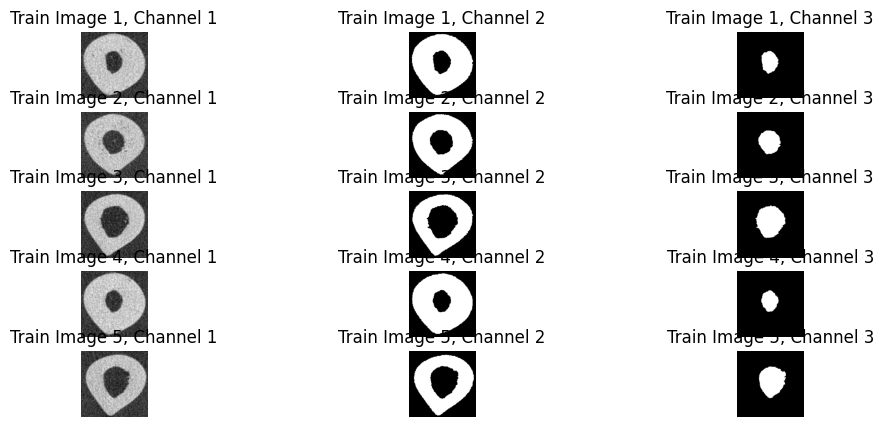

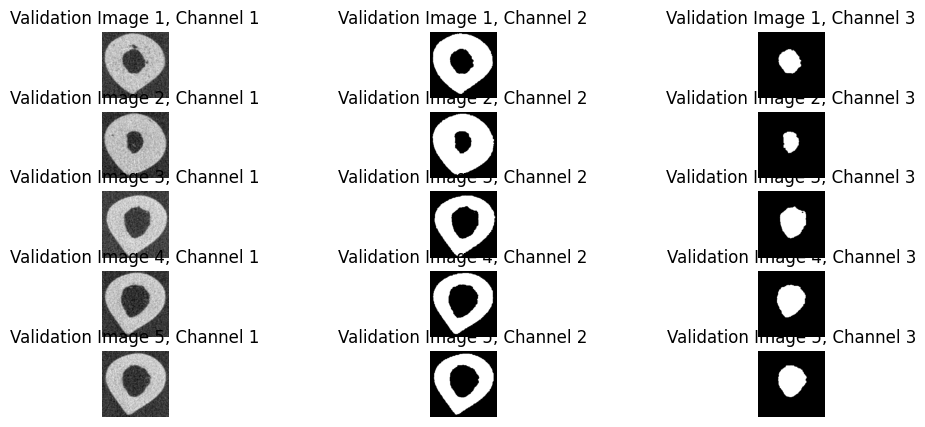

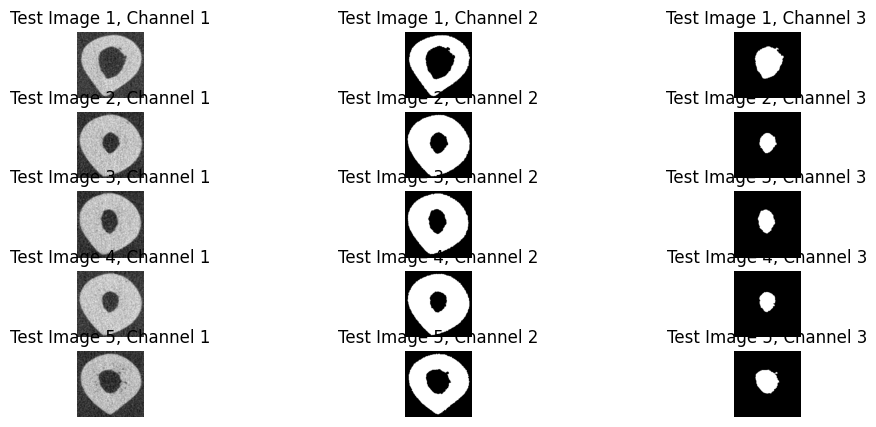

In [14]:
import matplotlib.pyplot as plt

# 훈련 세트 이미지 시각화
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    for channel in range(3):  # RGB 채널별로 시각화
        plt.subplot(5, 3, i * 3 + channel + 1)
        plt.imshow(X_train[i, :, :, channel], cmap='gray')
        plt.title(f"Train Image {i + 1}, Channel {channel + 1}")
        plt.axis("off")
plt.show()

# 검증 세트 이미지 시각화
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    for channel in range(3):  # RGB 채널별로 시각화
        plt.subplot(5, 3, i * 3 + channel + 1)
        plt.imshow(X_val[i, :, :, channel], cmap='gray')
        plt.title(f"Validation Image {i + 1}, Channel {channel + 1}")
        plt.axis("off")
plt.show()

# 테스트 세트 이미지 시각화
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    for channel in range(3):  # RGB 채널별로 시각화
        plt.subplot(5, 3, i * 3 + channel + 1)
        plt.imshow(X_test[i, :, :, channel], cmap='gray')
        plt.title(f"Test Image {i + 1}, Channel {channel + 1}")
        plt.axis("off")
plt.show()


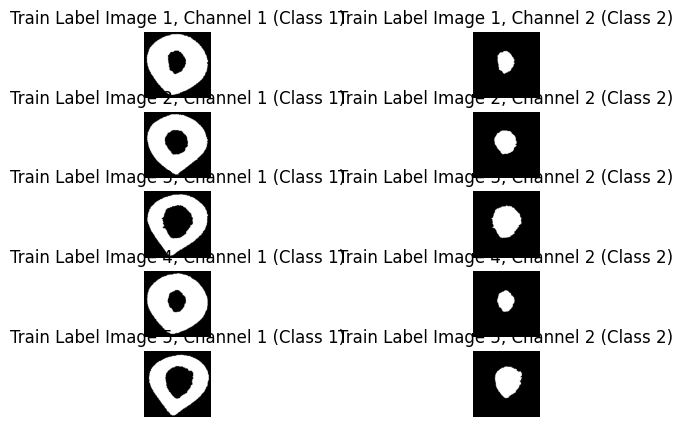

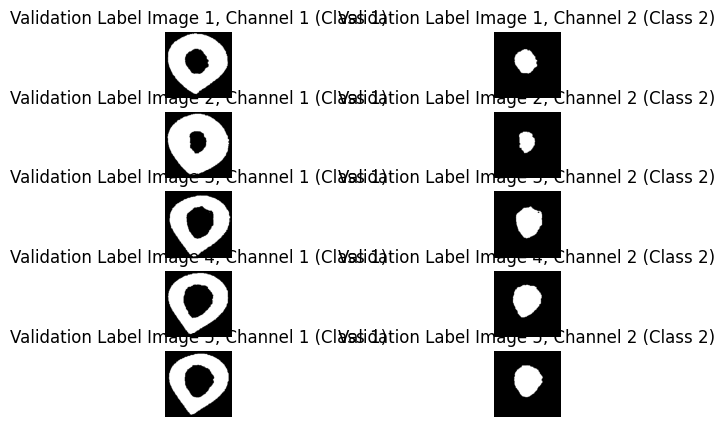

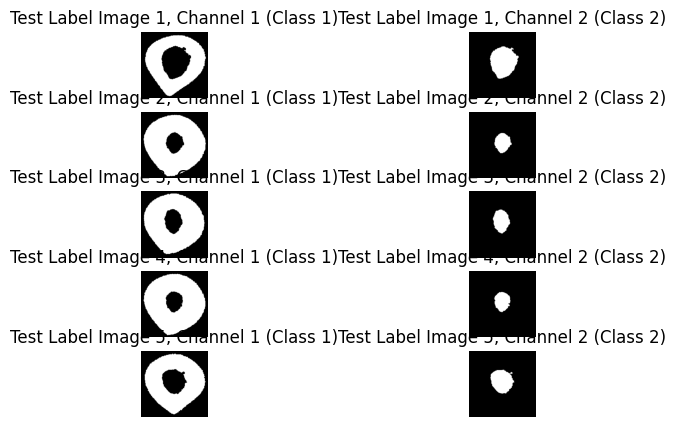

In [16]:
import matplotlib.pyplot as plt

# 훈련 세트 라벨 이미지 시각화 (첫 번째 클래스와 두 번째 클래스)
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(y_train[i, :, :, 0], cmap='gray')  # 첫 번째 채널을 시각화 (첫 번째 클래스)
    plt.title(f"Train Label Image {i + 1}, Channel 1 (Class 1)")
    plt.axis("off")
    
    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(y_train[i, :, :, 1], cmap='gray')  # 두 번째 채널을 시각화 (두 번째 클래스)
    plt.title(f"Train Label Image {i + 1}, Channel 2 (Class 2)")
    plt.axis("off")
    
plt.show()

# 검증 세트 라벨 이미지 시각화 (첫 번째 클래스와 두 번째 클래스)
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(y_val[i, :, :, 0], cmap='gray')  # 첫 번째 채널을 시각화 (첫 번째 클래스)
    plt.title(f"Validation Label Image {i + 1}, Channel 1 (Class 1)")
    plt.axis("off")
    
    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(y_val[i, :, :, 1], cmap='gray')  # 두 번째 채널을 시각화 (두 번째 클래스)
    plt.title(f"Validation Label Image {i + 1}, Channel 2 (Class 2)")
    plt.axis("off")
    
plt.show()

# 테스트 세트 라벨 이미지 시각화 (첫 번째 클래스와 두 번째 클래스)
plt.figure(figsize=(12, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(y_test[i, :, :, 0], cmap='gray')  # 첫 번째 채널을 시각화 (첫 번째 클래스)
    plt.title(f"Test Label Image {i + 1}, Channel 1 (Class 1)")
    plt.axis("off")
    
    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(y_test[i, :, :, 1], cmap='gray')  # 두 번째 채널을 시각화 (두 번째 클래스)
    plt.title(f"Test Label Image {i + 1}, Channel 2 (Class 2)")
    plt.axis("off")
    
plt.show()


In [82]:
from keras.losses import categorical_crossentropy
from keras.metrics import MeanIoU
from keras import backend as K
from keras.optimizers import Adam 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# 다중 클래스 세그멘테이션에 사용할 손실 함수
def multi_class_dice_loss(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1]
    smooth = 1e-5
    loss = 0
    for class_idx in range(num_classes):
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]
        intersection = K.sum(y_true_class * y_pred_class, axis=[1, 2])
        union = K.sum(y_true_class, axis=[1, 2]) + K.sum(y_pred_class, axis=[1, 2])
        dice = (2. * intersection + smooth) / (union + smooth)
        loss += 1 - dice
    return loss / num_classes

# 다중 클래스 세그멘테이션에 사용할 지표 (예: Mean Intersection over Union)
def mean_iou(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1]
    iou = 0
    for class_idx in range(num_classes):
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]
        iou += MeanIoU(num_classes=2)(y_true_class, K.round(y_pred_class))
    return iou / num_classes

# 클래스 수 설정
num_classes = 2

# 모델 컴파일 시 손실 함수와 지표 설정
model.compile(optimizer=Adam(learning_rate=1e-4), loss=multi_class_dice_loss, metrics=[mean_iou])


In [137]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

initial_lr = 1e-4

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1  # 학습률을 0.1배로 줄임

optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss={'mask1': 'categorical_crossentropy', 'mask2': 'categorical_crossentropy'}, metrics={'mask1': 'accuracy', 'mask2': 'accuracy'})

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


In [138]:
# 모델 초기화
input_shape = (512, 512, 3)  # 이미지 shape에 맞게 수정
inputs = Input(input_shape)
output_layer = u_model(inputs, start_neurons=16, DropoutRatio=0.25, num_classes=2)  # 사용자 정의 모델 u_model 사용

# 콜백 함수 설정
filename = '/Users/user/Desktop/Test u net model'
checkpointer = ModelCheckpoint(filepath=filename, monitor='val_mask2_accuracy', verbose=1, save_best_only=True, mode='max')


# 모델 컴파일
model.compile(
    optimizer='adam',
    loss={'mask1': 'categorical_crossentropy', 'mask2': 'categorical_crossentropy'},
    metrics={'mask1': 'accuracy', 'mask2': 'accuracy'}
)

# 모델 학습
epochs = 100
batch_size = 2
results = model.fit(
    X_train,
    {"mask1": y_train, "mask2": y_train},
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, {"mask1": y_val, "mask2": y_val}),
    callbacks=[checkpointer, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 2125.8374 - mask1_loss: 1044.5323 - mask2_loss: 1081.3043 - mask1_accuracy: 0.5773 - mask2_accuracy: 0.5704
Epoch 1: val_mask2_accuracy improved from -inf to 0.89515, saving model to /Users/user/Desktop/Test u net model
INFO:tensorflow:Assets written to: /Users/user/Desktop/Test u net model/assets


INFO:tensorflow:Assets written to: /Users/user/Desktop/Test u net model/assets


151/151 [==============================] - 442s 3s/step - loss: 2125.8374 - mask1_loss: 1044.5323 - mask2_loss: 1081.3043 - mask1_accuracy: 0.5773 - mask2_accuracy: 0.5704 - val_loss: 952.6621 - val_mask1_loss: 272.9091 - val_mask2_loss: 679.7529 - val_mask1_accuracy: 0.8745 - val_mask2_accuracy: 0.8952 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 1461.7050 - mask1_loss: 725.7269 - mask2_loss: 735.9785 - mask1_accuracy: 0.5563 - mask2_accuracy: 0.5495
Epoch 2: val_mask2_accuracy improved from 0.89515 to 0.89516, saving model to /Users/user/Desktop/Test u net model
INFO:tensorflow:Assets written to: /Users/user/Desktop/Test u net model/assets


INFO:tensorflow:Assets written to: /Users/user/Desktop/Test u net model/assets


151/151 [==============================] - 405s 3s/step - loss: 1461.7050 - mask1_loss: 725.7269 - mask2_loss: 735.9785 - mask1_accuracy: 0.5563 - mask2_accuracy: 0.5495 - val_loss: 2110.8914 - val_mask1_loss: 734.0761 - val_mask2_loss: 1376.8149 - val_mask1_accuracy: 0.8952 - val_mask2_accuracy: 0.8952 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 1725.9312 - mask1_loss: 837.7326 - mask2_loss: 888.1985 - mask1_accuracy: 0.5549 - mask2_accuracy: 0.5558
Epoch 3: val_mask2_accuracy did not improve from 0.89516
151/151 [==============================] - 401s 3s/step - loss: 1725.9312 - mask1_loss: 837.7326 - mask2_loss: 888.1985 - mask1_accuracy: 0.5549 - mask2_accuracy: 0.5558 - val_loss: 46.5595 - val_mask1_loss: 29.7236 - val_mask2_loss: 16.8359 - val_mask1_accuracy: 0.5526 - val_mask2_accuracy: 0.5515 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate t

KeyboardInterrupt: 

In [124]:
import os

# 모델을 저장할 디렉토리 경로
save_dir = '/Users/user/Desktop/model 12.18'  # 원하는 디렉토리 경로로 수정하세요.

# 디렉토리가 없으면 생성
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 모델을 저장합니다.
model.save(os.path.join(save_dir, 'your_model.h5'))



In [125]:
from keras.models import load_model

# 저장한 모델 파일 경로
model_path = os.path.join(save_dir, 'your_model.h5')

# 모델을 로드합니다.
loaded_model = load_model(model_path)

# 로드한 모델을 사용하여 예측 등을 수행할 수 있습니다.


4/4 [==============================] - 27s 6s/step


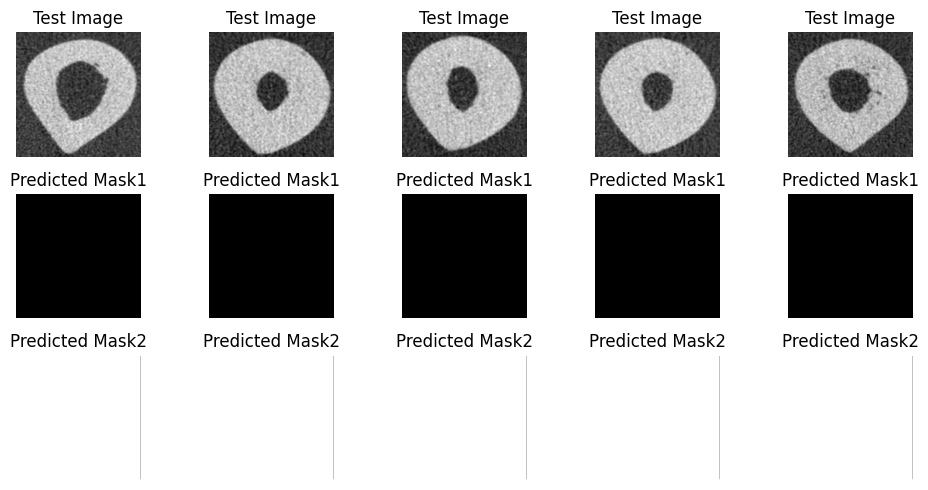

In [127]:
import matplotlib.pyplot as plt

# 테스트 데이터로 mask1 및 mask2 예측
mask1_predictions, mask2_predictions = loaded_model.predict(X_test)

plt.figure(figsize=(10, 5))
for i in range(5):  # 처음 5개 이미지만 시각화
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i][:, :, 0], cmap='gray')  # 테스트 이미지의 첫 번째 채널
    plt.title('Test Image')
    plt.axis('off')
    
    plt.subplot(3, 5, i + 6)
    plt.imshow(mask1_predictions[i][:, :, 0], cmap='gray')  # mask1 예측 이미지의 첫 번째 채널
    plt.title('Predicted Mask1')
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(mask2_predictions[i][:, :, 0], cmap='gray')  # mask2 예측 이미지의 첫 번째 채널
    plt.title('Predicted Mask2')
    plt.axis('off')

plt.tight_layout()
plt.show()



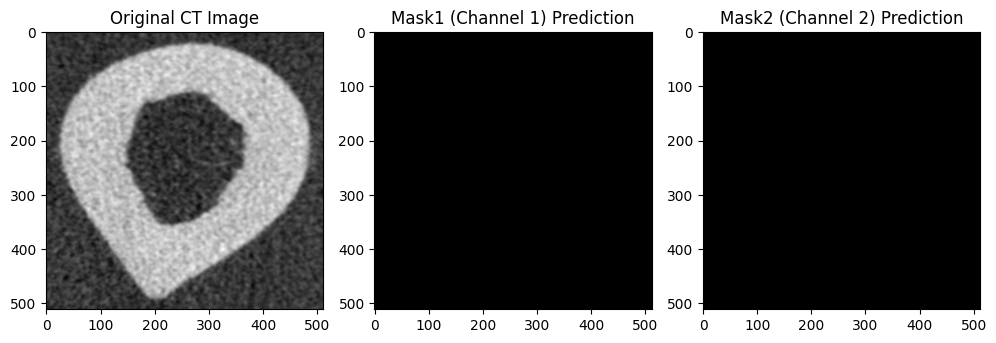

In [123]:
import matplotlib.pyplot as plt

import random

# 랜덤한 인덱스 선택
index = random.randint(0, len(X_test) - 1)

# 선택된 인덱스로 이미지와 예측 결과 가져오기
image_to_visualize = X_test[index]
mask1_to_visualize = mask1_predictions[index]
mask2_to_visualize = mask2_predictions[index]


# 이미지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(image_to_visualize[:, :, 0], cmap='gray')  # CT 이미지 표시
plt.title('Original CT Image')

# mask1 예측 결과 시각화 (첫 번째 채널)
plt.subplot(132)
plt.imshow(mask1_to_visualize[:, :, 0], cmap='gray')  # mask1의 첫 번째 채널 시각화
plt.title('Mask1 (Channel 1) Prediction')

# mask2 예측 결과 시각화 (두 번째 채널)
plt.subplot(133)
plt.imshow(mask2_to_visualize[:, :, 1], cmap='gray')  # mask2의 두 번째 채널 시각화
plt.title('Mask2 (Channel 2) Prediction')

plt.tight_layout()
plt.show()


In [47]:
print(X_test.shape)

(101, 512, 512, 3)


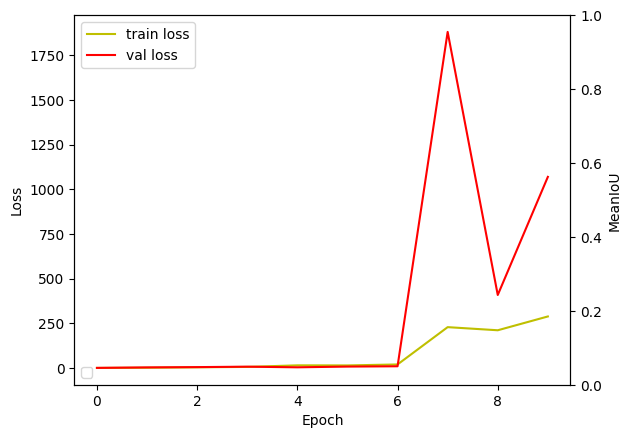

In [139]:
import matplotlib.pyplot as plt

# Loss와 MeanIoU 그래프 생성
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

# history 변수로 변경
loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

# MeanIoU 관련 키 이름 확인 후 수정
mean_iou_train_keys = [key for key in results.history.keys() if 'mean_io_u' in key and 'train' in key]
mean_iou_val_keys = [key for key in results.history.keys() if 'mean_io_u' in key and 'val' in key]

for key in mean_iou_train_keys:
    acc_ax.plot(results.history[key], label=key)

for key in mean_iou_val_keys:
    acc_ax.plot(results.history[key], label=key)

loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
acc_ax.set_ylabel('MeanIoU')

# 그래프 레전드 설정
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
